In [ ]:
import numpy as np
import pandas as pd
import sklearn
import itertools

## Reading and Separating Data

In [ ]:
df_ml = pd.read_csv("../data/data_ml.csv")

In [ ]:
separation_date = "2013-12-31"
df_train = df_ml.query("date < @separation_date").copy()
df_test = df_ml.query("@separation_date <= date & date < '2018-12-31'").copy()

In [ ]:
columns_to_drop = [
    "stock_id", "date", # non-feature identifiers
    "R1M_Usd", "R3M_Usd", "R6M_Usd", "R12M_Usd", # numerical labels
    "R1M_Usd_C", "R12M_Usd_C" # categorical labels
]

features = list(df_ml.drop(columns=columns_to_drop).columns)

In [ ]:
X_train = df_train[features]
y_train = df_train["R1M_Usd_C"]

In [ ]:
X_test = df_test[features]
y_test = df_test["R1M_Usd_C"]

In [ ]:
rebalance_dates = list(np.sort(df_test["date"].unique()))

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

In [ ]:
def get_fitting_backtesting_results(specified_model):
    # fitting cross-validation results
    cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    scoring = [
        "accuracy",
        "precision",
        "recall",
        "roc_auc"
    ]
    results_cv = cross_validate(specified_model, X_train, y_train, scoring=scoring, cv=cv)
    accuracy_mean = results_cv['test_accuracy'].mean()
    precision_mean = results_cv['test_precision'].mean()
    recall_mean = results_cv['test_recall'].mean()
    roc_auc_mean = results_cv['test_roc_auc'].mean()

    # final fitting
    model = specified_model
    model.fit(X_train, y_train)

    # generating inferences
    df_screen = df_test[["date", "R1M_Usd"]].copy().reset_index(drop=True)
    df_screen["pred_hard"] = model.predict(X_test)
    df_screen["pred_prob"] = model.predict_proba(X_test)[:,1]

    # hard-prediction
    df_monthly_returns = df_screen.query("pred_hard==1").groupby(["date"])[["R1M_Usd"]].mean().reset_index()
    df_monthly_returns['growth_factor'] = 1 + df_monthly_returns['R1M_Usd']
    df_monthly_returns['equity_curve'] = df_monthly_returns['growth_factor'].cumprod()
    annual_return_hp = ((df_monthly_returns['equity_curve'].iloc[-1]) ** (12 / len(df_monthly_returns))) - 1
    sharpe_ratio_hp = (df_monthly_returns["R1M_Usd"].mean() / df_monthly_returns["R1M_Usd"].std()) * np.sqrt(12)
    
    # top-200 trades
    rebalance_dates = list(np.sort(df_screen["date"].unique()))
    lst_trades = []
    for ix_date in rebalance_dates:
        df = df_screen.query("date == @ix_date").sort_values(by="pred_prob", ascending=False).head(200).copy()
        lst_trades.append(df)
    df_trades = pd.concat(lst_trades)
    
    # top-200 return and sharpe-ratio
    df_monthly_returns = df_trades.groupby("date")[["R1M_Usd"]].mean().reset_index()
    df_monthly_returns['growth_factor'] = 1 + df_monthly_returns['R1M_Usd']
    df_monthly_returns['equity_curve'] = df_monthly_returns['growth_factor'].cumprod()
    annual_return_top = ((df_monthly_returns['equity_curve'].iloc[-1]) ** (12 / len(df_monthly_returns))) - 1
    sharpe_ratio_top = (df_monthly_returns["R1M_Usd"].mean() / df_monthly_returns["R1M_Usd"].std()) * np.sqrt(12)

    # putting results into a DataFrame - Random Forest
    df_results = pd.DataFrame({
        "model_family":["random_forest"],
        "model_name":[str(model)],
        "n_estimators":[model.get_params()["n_estimators"]],
        "criterion":[model.get_params()["criterion"]],
        "max_depth":[model.get_params()["max_depth"]],
        "max_features":[model.get_params()["max_features"]],
        "accuracy":[accuracy_mean],
        "precision":[precision_mean],
        "recall":[recall_mean],
        "roc_auc":[roc_auc_mean],
        "hp_ann_ret":[annual_return_hp],
        "hp_sharpe":[sharpe_ratio_hp],
        "top_200_ann_ret":[annual_return_top],
        "top_200_sharpe":[sharpe_ratio_top],
    })

    return df_results

## Logistic Regression

In [ ]:
#get_fitting_backtesting_results(LogisticRegression(penalty=None))

In [ ]:
# #penalty = ["l2"]
# penalty = [None]
# #C = np.logspace(-5, 1, 7)
# solver = ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"]
# results = []
# ix_counter = 1
# for ix_param in itertools.product(penalty, solver):
#     #specified_model = LogisticRegression(penalty=ix_param[0], C=ix_param[1], solver=ix_param[2], max_iter=10000, n_jobs=-1)
#     specified_model = LogisticRegression(penalty=ix_param[0], solver=ix_param[1], max_iter=10000, n_jobs=-1)
#     print(ix_counter, specified_model)
#     df = get_fitting_backtesting_results(specified_model)
#     results.append(df)
#     ix_counter +=  1
# df_results = pd.concat(results)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df_result = get_fitting_backtesting_results(RandomForestClassifier(max_depth=5, n_jobs=-1))

In [ ]:
df_result

,model_family,model_name,n_estimators,criterion,max_depth,max_features,accuracy,precision,recall,roc_auc,hp_ann_ret,hp_sharpe,top_200_ann_ret,top_200_sharpe
0,random_forest,"RandomForestClassifier(max_depth=5, n_jobs=-1)",100,gini,5,sqrt,0.520339,0.516207,0.560398,0.529302,0.091449,0.665619,0.173162,0.921443


In [ ]:
n_estimators = [100] #[25, 50, 100, 150, 200]
criterion = ["gini", "entropy", "log_loss"]
max_depth = [2, 4, 6, 8, 10, 12, 14]
max_features = ["sqrt", "log2", None, 0.1, 0.25, 0.5, 0.75]
results = []
ix_counter = 1
for ix_param in itertools.product(n_estimators, criterion, max_depth, max_features):
    specified_model = RandomForestClassifier(
        n_estimators=ix_param[0],
        criterion=ix_param[1],
        max_depth=ix_param[2],
        max_features=ix_param[3],
        n_jobs=-1
    )
    print(ix_counter, specified_model)
    df = get_fitting_backtesting_results(specified_model)
    results.append(df)
    ix_counter +=  1
df_results = pd.concat(results)

1 RandomForestClassifier(max_depth=2, n_jobs=-1)
2 RandomForestClassifier(max_depth=2, max_features='log2', n_jobs=-1)
3 RandomForestClassifier(max_depth=2, max_features=None, n_jobs=-1)
4 RandomForestClassifier(max_depth=2, max_features=0.1, n_jobs=-1)
5 RandomForestClassifier(max_depth=2, max_features=0.25, n_jobs=-1)
6 RandomForestClassifier(max_depth=2, max_features=0.5, n_jobs=-1)
7 RandomForestClassifier(max_depth=2, max_features=0.75, n_jobs=-1)
8 RandomForestClassifier(max_depth=4, n_jobs=-1)
9 RandomForestClassifier(max_depth=4, max_features='log2', n_jobs=-1)
10 RandomForestClassifier(max_depth=4, max_features=None, n_jobs=-1)
11 RandomForestClassifier(max_depth=4, max_features=0.1, n_jobs=-1)
12 RandomForestClassifier(max_depth=4, max_features=0.25, n_jobs=-1)
13 RandomForestClassifier(max_depth=4, max_features=0.5, n_jobs=-1)
14 RandomForestClassifier(max_depth=4, max_features=0.75, n_jobs=-1)
15 RandomForestClassifier(max_depth=6, n_jobs=-1)
16 RandomForestClassifier(max_d

In [ ]:
# df_results = pd.concat(results)
df_results

,model_family,model_name,n_estimators,criterion,max_depth,max_features,accuracy,precision,recall,roc_auc,hp_ann_ret,hp_sharpe,top_200_ann_ret,top_200_sharpe
0,random_forest,"RandomForestClassifier(max_depth=2, n_jobs=-1)",100,gini,2,sqrt,0.513915,0.510113,0.570324,0.521737,0.079022,0.604913,0.074432,0.502174
0,random_forest,"RandomForestClassifier(max_depth=2, max_featur...",100,gini,2,log2,0.514284,0.510890,0.541756,0.521457,0.089459,0.657308,0.120297,0.734731
0,random_forest,"RandomForestClassifier(max_depth=2, max_featur...",100,gini,2,None,0.512425,0.508238,0.606929,0.520766,0.079313,0.610679,0.113730,0.737470
0,random_forest,"RandomForestClassifier(max_depth=2, max_featur...",100,gini,2,0.1,0.513344,0.509095,0.591903,0.521390,0.089363,0.661833,0.143528,0.822493
0,random_forest,"RandomForestClassifier(max_depth=2, max_featur...",100,gini,2,0.25,0.513112,0.508806,0.596068,0.521166,0.082600,0.631760,0.119373,0.728530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,random_forest,"RandomForestClassifier(criterion='log_loss', m...",100,log_loss,14,None,0.522077,0.518533,0.540872,0.531265,0.102578,0.710258,0.172638,0.919325
0,random_forest,"RandomForestClassifier(criterion='log_loss', m...",100,log_loss,14,0.1,0.519567,0.515928,0.544590,0.527346,0.099576,0.707332,0.148563,0.809839
0,random_forest,"RandomForestClassifier(criterion='log_loss', m...",100,log_loss,14,0.25,0.520314,0.516574,0.547201,0.528351,0.105384,0.738849,0.169309,0.925208
0,random_forest,"RandomForestClassifier(criterion='log_loss', m...",100,log_loss,14,0.5,0.520385,0.516821,0.541674,0.528604,0.103782,0.735062,0.164219,0.872942


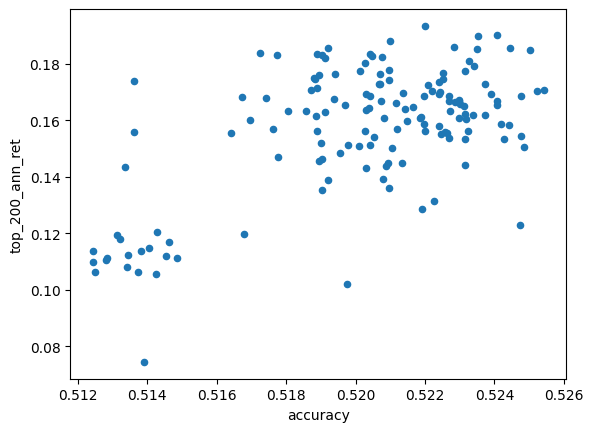

In [ ]:
df_results.plot(x="accuracy", y="top_200_ann_ret", kind="scatter");

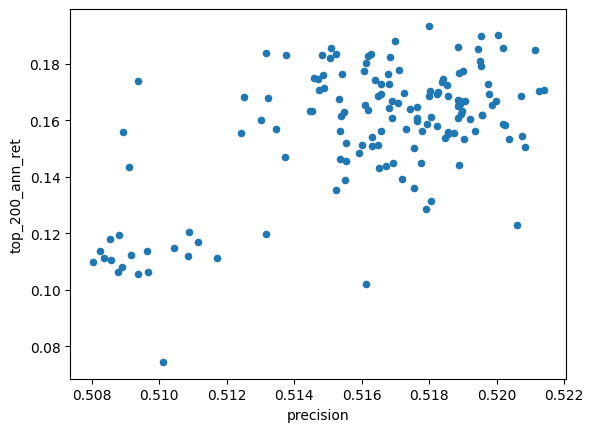

In [ ]:
df_results.plot(x="precision", y="top_200_ann_ret", kind="scatter");

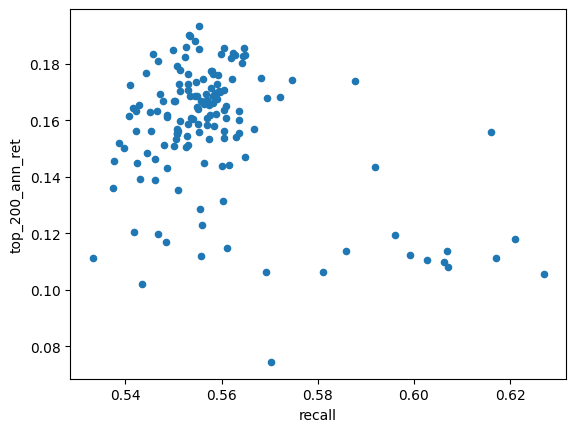

In [ ]:
df_results.plot(x="recall", y="top_200_ann_ret", kind="scatter");

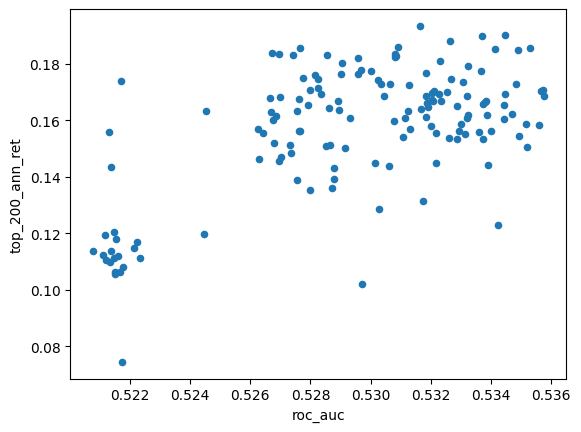

In [ ]:
df_results.plot(x="roc_auc", y="top_200_ann_ret", kind="scatter");

In [ ]:
#np.logspace(-5, 2, 8)
df_results.to_csv("../data/many_models_random_forest_100.csv", index=False)

In [ ]:
# penalty = ["l1", "l2"]
# C = np.logspace(-5, 2, 8)
# solver = ["lbfgs", "newton-cg", "newton-cholesky", "sag"]

# lst = []
# for ix_parameters in itertools.product(penalty, C, solver):
#     lst.append(ix_parameters)
# len(lst)

In [ ]:
# df_results["hp_ann_ret"].hist()

In [ ]:
# df_results["top_200_ann_ret"].hist(bins=50);

In [ ]:
# df_results[["top_200_ann_ret"]].describe()

In [ ]:
#LogisticRegression(C=10.0, max_iter=10000, n_jobs=-1, solver='sag')
#LogisticRegression(C=10.0, max_iter=10000, n_jobs=-1, solver='saga')